In [1]:
import findspark
findspark.init()

import wptools
import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

from pyspark.sql import dataframe
from pyspark.sql import functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import re
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

%matplotlib inline

import os
import sys
my_fun = '../'
if my_fun not in sys.path:
    sys.path.append(my_fun)
    
from get_ref_info import *
my_fun = '../utils/cleaning/'
if my_fun not in sys.path:
    sys.path.append(my_fun)
    
from cleaning import *
from operator import add

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse

import seaborn as sns
import numpy as np
from pyspark.sql.functions import regexp_replace, col

from sklearn.preprocessing import MinMaxScaler

DATA_DIR = '../../data/data_processed/' 

sc.addPyFile("../get_ref_info.py")
sc.addPyFile("../cleaning/cleaning.py")

In [2]:
# Loading the data
WIKIPEDIA_REFERENCES_PARQUET = DATA_DIR + "intermediate/wikipedia_no_outliers.parquet"

# loading the saved parquet files
wikipedia_ref = spark.read.parquet(WIKIPEDIA_REFERENCES_PARQUET)
wikipedia_ref.show(10)

+------+--------------------+-----------------+--------------------+
|    id|               title|       categories|            revision|
+------+--------------------+-----------------+--------------------+
|655845|Battle of Athens ...|military conflict|[, [,, 5175837,, ...|
|656035|  Battle of Calabria|military conflict|[[link,], [,, 268...|
|656087|   Italo-Turkish War|military conflict|[, [,,, 96.77.37....|
|656173|Third Anglo-Afgha...|military conflict|[[Formatting.,], ...|
|656175|Second Anglo-Afgh...|military conflict|[[/* 1879 */The B...|
|656473|   Illinois campaign|military conflict|[[Moved images.,]...|
|659156|Battle of Kock (1...|military conflict|[, [,, 29980587,,...|
|659506|Battle of Peachtr...|military conflict|[[c/e.,], [,, 193...|
|661656|Nicaraguan Revolu...|military conflict|[, [,, 33124044,,...|
|661864|       S11 (protest)|   civil conflict|[[Rescuing 3 sour...|
+------+--------------------+-----------------+--------------------+
only showing top 10 rows



In [3]:
articles = pd.read_csv(DATA_DIR + 'articles_popularity_score.csv')
articles.head()

,id,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing,popularity_score
0,771,American Revolutionary War,military conflict,0.375011,0.259929,0.598,0.634364,70000,Eastern North America|Caribbean Sea|Indian ...,1783.0,False,1.867305
1,863,American Civil War,military conflict,0.319410,0.522999,0.212,0.532646,828000,Southern United States Q49042|Northern Uni...,1865.0,False,1.587055
2,3793,Battle of Bosworth Field,military conflict,0.152325,0.032733,0.034,0.208935,0,Ambion Hill Q4741491|Battle of Bosworth F...,1485.0,False,0.427993
3,4005,Battle of Pharsalus,military conflict,0.034510,0.017785,0.020,0.067354,230,Farsala Q985596,0.0,False,0.139650
4,4049,Battle of Blenheim,military conflict,0.104371,0.013543,0.095,0.137457,24968,Blindheim Q514914,1704.0,False,0.350371


In [4]:
articles_copy = articles.copy()

### Get the domains of references

In [18]:
wikipedia_ref.select('title').where("id = '655845'").head()

Row(title='Battle of Athens (1946)')

In [14]:
references_rrd = wikipedia_ref.rdd.flatMap(get_ref_info)
references = sqlContext.createDataFrame(references_rrd)
references.show(3)

+------+---------+--------------------+--------------------+
|    id| template|               title|                 url|
+------+---------+--------------------+--------------------+
|655845|cite book|Battle of Athens ...|                    |
|655845|cite book|Battle of Athens ...|https://archive.o...|
|655845|cite book|Battle of Athens ...|                    |
+------+---------+--------------------+--------------------+
only showing top 3 rows



**URL parsing** Parse a URL into six components, returning a 6-tuple. This corresponds to the general structure of a URL: scheme://netloc/path;parameters?query#fragment. Each tuple item is a string, possibly empty.

In [21]:
def id_(entity):
    if entity.url != '': 
        parsed_url = urlparse(entity.url)
        print('{uri.netloc}'.format(uri=parsed_url))
        return Row(id=entity.id, title=entity.title, url='{uri.netloc}'.format(uri=parsed_url))
    else:
        return Row(id=entity.id, title=entity.title, url=entity.url)

In [22]:
mapped_id_ref_df = sqlContext.createDataFrame(references.where("length(url)>0").rdd.map(id_))
mapped_id_ref_df.show(5)

+------+--------------------+--------------------+
|    id|               title|                 url|
+------+--------------------+--------------------+
|655845|Battle of Athens ...|         archive.org|
|655845|Battle of Athens ...|         archive.org|
|655845|Battle of Athens ...|www.americanherit...|
|655845|Battle of Athens ...|         archive.org|
|655845|Battle of Athens ...|         archive.org|
+------+--------------------+--------------------+
only showing top 5 rows



In [23]:
# remove duplicates 
id_ref_without_duplicates = mapped_id_ref_df\
.dropDuplicates(["id", "url"])

In [24]:
id_ref_without_duplicates.where("id = '655845'").head(25)

[Row(id=655845, title='Battle of Athens (1946)', url='timesmachine.nytimes.com'),
 Row(id=655845, title='Battle of Athens (1946)', url='www.americanheritage.com'),
 Row(id=655845, title='Battle of Athens (1946)', url='volweb.utk.edu'),
 Row(id=655845, title='Battle of Athens (1946)', url='archive.org'),
 Row(id=655845, title='Battle of Athens (1946)', url='www.nytimes.com'),
 Row(id=655845, title='Battle of Athens (1946)', url='www.imdb.com'),
 Row(id=655845, title='Battle of Athens (1946)', url='www.tn.gov'),
 Row(id=655845, title='Battle of Athens (1946)', url='tennesseeencyclopedia.net')]

In [5]:
articles_copy.dtypes

id                    int64
title                object
categories           object
article_lenght      float64
views               float64
refs_count          float64
link_count          float64
death                 int64
locations            object
end_date_clean      float64
ongoing                bool
popularity_score    float64
dtype: object

In [87]:
# articles_after_1995.rename({'Unnamed: 0' : 'id'}, axis='columns', inplace=True)

In [6]:
articles_copy = articles_copy.copy()

In [7]:
for col in articles_copy.columns:
    articles_copy[col] = articles_copy[col].astype('str')

In [8]:
articles_copy.head()

,id,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing,popularity_score
0,771,American Revolutionary War,military conflict,0.3750112057020904,0.2599290677120721,0.598,0.634364261168385,70000,Eastern North America|Caribbean Sea|Indian ...,1783.0,False,1.8673045345825476
1,863,American Civil War,military conflict,0.3194104778425917,0.5229986430697001,0.212,0.5326460481099656,828000,Southern United States Q49042|Northern Uni...,1865.0,False,1.5870551690222574
2,3793,Battle of Bosworth Field,military conflict,0.15232520284286696,0.032732866135706445,0.034,0.20893470790378008,0,Ambion Hill Q4741491|Battle of Bosworth F...,1485.0,False,0.4279927768823535
3,4005,Battle of Pharsalus,military conflict,0.03451041697793617,0.01778526501901189,0.02,0.06735395189003437,230,Farsala Q985596,0.0,False,0.13964963388698245
4,4049,Battle of Blenheim,military conflict,0.10437108881678796,0.013543088263183891,0.095,0.13745704467353953,24968,Blindheim Q514914,1704.0,False,0.3503712217535114


In [9]:
articles_copy.dtypes

id                  object
title               object
categories          object
article_lenght      object
views               object
refs_count          object
link_count          object
death               object
locations           object
end_date_clean      object
ongoing             object
popularity_score    object
dtype: object

In [10]:
articles_copy_spark = sqlContext.createDataFrame(articles_copy)

In [11]:
articles_copy_spark.head(5)

[Row(id='771', title='American Revolutionary War', categories='military conflict', article_lenght='0.3750112057020904', views='0.2599290677120721', refs_count='0.598', link_count='0.634364261168385', death='70000', locations='Eastern  North  America|Caribbean  Sea|Indian  subcontinent|Africa|the  Atlantic  Ocean|and  the  Indian  Ocean', end_date_clean='1783.0', ongoing='False', popularity_score='1.8673045345825476'),
 Row(id='863', title='American Civil War', categories='military conflict', article_lenght='0.3194104778425917', views='0.5229986430697001', refs_count='0.212', link_count='0.5326460481099656', death='828000', locations='Southern  United  States  Q49042|Northern  United  States  Q1357541', end_date_clean='1865.0', ongoing='False', popularity_score='1.5870551690222574'),
 Row(id='3793', title='Battle of Bosworth Field', categories='military conflict', article_lenght='0.15232520284286696', views='0.032732866135706445', refs_count='0.034', link_count='0.20893470790378008', de

In [12]:
articles_copy_spark_id = articles_copy_spark.select('id','title','popularity_score', 'death', 'end_date_clean','ongoing')\
                    .orderBy('popularity_score', ascending=False)
articles_copy_spark_id.show(3)


+-------+------------+------------------+--------+--------------+-------+
|     id|       title|  popularity_score|   death|end_date_clean|ongoing|
+-------+------------+------------------+--------+--------------+-------+
|  32927|World War II| 2.588224979043371|73000000|        1945.0|  False|
|  32611| Vietnam War|2.5555182965941783|  950765|        1975.0|  False|
|4764461| World War I|2.4910017841780943|17000000|        1918.0|  False|
+-------+------------+------------------+--------+--------------+-------+
only showing top 3 rows



In [71]:
"""articles_copy_spark_id_date = articles_copy_spark_id.registerTempTable(
    'articles_copy_spark_id_date'
)
id_ref_without_duplicates_sql = id_ref_without_duplicates.registerTempTable('id_ref_without_duplicates_sql')

query_get_references_for_id = """
select art.id, art.title, art.popularity_score, art.death, art.end_date_clean, art.ongoing, ref.url
from articles_copy_spark_id_date as art
join id_ref_without_duplicates_sql as ref
on art.id = ref.id
"""

join_ref_ = spark.sql(query_get_references_for_id)
join_ref_.show(5)"""

+------+----------------+------------------+-----+--------------+-------+--------------------+
|    id|           title|  popularity_score|death|end_date_clean|ongoing|                 url|
+------+----------------+------------------+-----+--------------+-------+--------------------+
|  4823|     Balkan Wars|0.3709030455420643|    0|        1913.0|  False|macedonia-istinat...|
|  4823|     Balkan Wars|0.3709030455420643|    0|        1913.0|  False|   countrystudies.us|
|381602|Baby Face Nelson|0.2746420418032183|    0|           0.0|  False|    books.google.com|
|381602|Baby Face Nelson|0.2746420418032183|    0|           0.0|  False|        data.bls.gov|
|381602|Baby Face Nelson|0.2746420418032183|    0|           0.0|  False|         variety.com|
+------+----------------+------------------+-----+--------------+-------+--------------------+
only showing top 5 rows



In [15]:
# select correct id given by my_articles_after_1995_copy_spark_id and give these id to references table
articles_copy_spark_id_date = articles_copy_spark_id.registerTempTable(
    'articles_copy_spark_id_date'
)
references_sql = references.registerTempTable('references_sql')

query_get_id = """
select art.id, art.title, refu.url, art.end_date_clean
from articles_copy_spark_id_date as art
join references_sql as refu
on art.id = refu.id
"""

id_to_get_domains = spark.sql(query_get_id)
id_to_get_domains.show(5)

+------+----------------+--------------------+--------------+
|    id|           title|                 url|end_date_clean|
+------+----------------+--------------------+--------------+
|  4823|     Balkan Wars|                    |        1913.0|
|  4823|     Balkan Wars|http://countrystu...|        1913.0|
|  4823|     Balkan Wars|http://macedonia-...|        1913.0|
|  4823|     Balkan Wars|                    |        1913.0|
|381602|Baby Face Nelson|                    |           0.0|
+------+----------------+--------------------+--------------+
only showing top 5 rows



In [16]:
#id_to_get_domains_date = id_to_get_domains.filter("end_date_clean >= '1980' AND end_date_clean <= '1990'")

id_to_get_domains_date = id_to_get_domains.filter("end_date_clean >= '1995'")

# Cout the # references per domain

In [17]:
def get_domain(row):
    # parse url and return for each row (url, 1) where 1 is the occurence of ref = 1 for that page
    try:
        parsed_uri = urlparse(row['url'])
        return ('{uri.netloc}'.format(uri=parsed_uri), 1)
    except:
        return None

mapped_domains = id_to_get_domains_date.where("length(url)>0").rdd.map(get_domain).filter(lambda row: row is not None)
# for each domain count how many references there are in total to find top domains
domains_count = mapped_domains.reduceByKey(lambda a,b: a+b).filter(lambda r: len(r[0])>0).sortBy(lambda r: -r[1])
domains_count.take(30)

[('www.almasdarnews.com', 3378),
 ('www.reuters.com', 3172),
 ('www.nytimes.com', 2846),
 ('www.theguardian.com', 2620),
 ('www.bbc.co.uk', 2137),
 ('news.bbc.co.uk', 1779),
 ('www.bbc.com', 1726),
 ('www.aljazeera.com', 1648),
 ('www.washingtonpost.com', 1560),
 ('www.syriahr.com', 1463),
 ('books.google.com', 1456),
 ('www.cnn.com', 1311),
 ('www.telegraph.co.uk', 1205),
 ('edition.cnn.com', 947),
 ('www.independent.co.uk', 784),
 ('abcnews.go.com', 733),
 ('twitter.com', 632),
 ('www.dailystar.com.lb', 631),
 ('www.foxnews.com', 609),
 ('www.haaretz.com', 576),
 ('www.dawn.com', 554),
 ('www.jpost.com', 548),
 ('www.iraqinews.com', 542),
 ('news.yahoo.com', 540),
 ('www.wsj.com', 529),
 ('www.cbsnews.com', 523),
 ('www.latimes.com', 487),
 ('www.dailymail.co.uk', 482),
 ('www.usatoday.com', 481),
 ('www.huffingtonpost.com', 471)]

In [18]:
# count the number of links
number_links = domains_count.map(lambda r: r[1]).reduce(add)
print("Total number of links: {}".format(number_links))

Total number of links: 107395


In [19]:
domains_distribution_df = sqlContext.createDataFrame(domains_count)
domains_distribution_pd = domains_distribution_df.toPandas().set_index('_1')

domains_distribution_pd.rename({'_1' : 'id', '_2':'nb_ref'}, axis='columns', inplace=True)

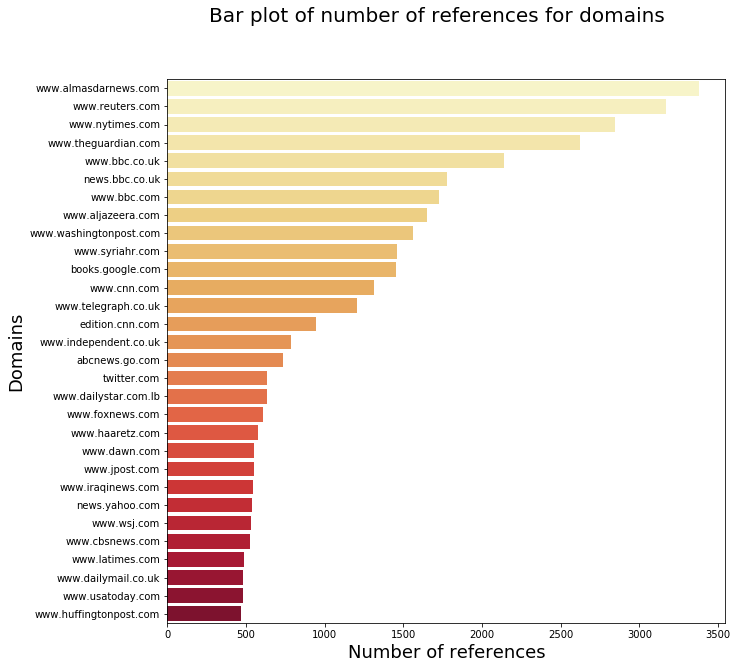

In [22]:
domains_distribution_pd30 = domains_distribution_pd.head(30)

# plot using bar plot
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(domains_distribution_pd30['nb_ref'], domains_distribution_pd30.index, palette="YlOrRd", ax=ax1, orient='h')
plt.xlabel('Number of references',fontsize=18)
plt.ylabel('Domains',fontsize=18)
f.suptitle('Bar plot of number of references for domains', fontsize=20)
f.set_size_inches(10, 10)
plt.show()

In [111]:
not_pop_articles_spark_id = articles_spark.select('id','title','popularity_score', 'death', 'end_date_clean','ongoing')\
                    .orderBy('popularity_score', ascending=True)

In [120]:
not_pop_articles_spark_id.select('id','title').head(150)

[Row(id='49532277', title='Hashimiya attack'),
 Row(id='58421339', title='Fifth Third Center shooting'),
 Row(id='49429205', title='January 2015 Maiduguri suicide bombing'),
 Row(id='50567259', title='Transkei War'),
 Row(id='56640476', title='Operation of Sidi Aïch'),
 Row(id='32166814', title='Conquest of Ai'),
 Row(id='51033965', title='Punjab War'),
 Row(id='41345416', title='Battle of Deefa'),
 Row(id='3216047', title='Sack of Dun Gallimhe'),
 Row(id='49532230', title='5 February 2014 Baghdad bombings'),
 Row(id='53563856', title='Second Battle of Nanning'),
 Row(id='50373289', title='Sizzlers massacre'),
 Row(id='49429234', title='Monguno bombing'),
 Row(id='38928141', title='Battle of Møn (1657)'),
 Row(id='27494892', title='Battle of Maison Carrée'),
 Row(id='48494190', title='Kurram incident'),
 Row(id='3155017', title='Battle of the Baetis River'),
 Row(id='53563811', title='Battle of Nanning'),
 Row(id='52422234', title='Battle of Mizpah'),
 Row(id='6304854', title='Battle o

In [126]:
articles[
    (articles.end_date_clean > 2000) & (articles.popularity_score > 0.2) & (articles.popularity_score < 1.5) 
].sort_values(by='popularity_score').head(200)

,id,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing,popularity_score
15430,50445824,Western Iran clashes (2016–present),military conflict,0.062986,0.000470,0.068,0.069416,116,Kurdistan Province Q134386,2016.0,False,0.200872
15533,50869354,Siege of Darayya and Muadamiyat,military conflict,0.057254,0.001112,0.076,0.066667,0,Darayya Q1033066,2016.0,False,0.201033
12700,38987750,Beitunia killings,civilian attack,0.073637,0.000228,0.074,0.053608,2,Beitunia Q528941,2014.0,False,0.201473
14346,45560460,Eastern al-Hasakah offensive,military conflict,0.060281,0.000900,0.071,0.069416,182,Al- Hasakah Governorate Q233914,2015.0,False,0.201597
15002,48667439,Colorado Springs Planned Parenthood shooting,"civilian attack, criminal",0.053533,0.007723,0.062,0.078351,3,Colorado Springs Q49258|Planned Parenthood ...,2015.0,False,0.201606
12090,36644646,August 2012 Sinai attack,civilian attack,0.067775,0.000361,0.068,0.066667,24,Sinai Peninsula Q36755,2012.0,False,0.202803
9946,28892945,Rocket attacks on Eilat and Aqaba,"civilian attack, civilian attack, civilian att...",0.045650,0.000479,0.058,0.098969,0,Eilat Q134762|Aqaba Q180522,2017.0,False,0.203098
15636,51274658,2016 Ethiopian protests,civil conflict,0.044717,0.004066,0.054,0.100344,0,Amhara Region|Gondar|Addis Ababa|Bahir Dar|...,2018.0,False,0.203127
1783,1173504,First Ivorian Civil War,military conflict,0.060409,0.005244,0.041,0.096907,1500,Ivory Coast Q1008,2007.0,False,0.203560
15253,49584267,Siege of Fallujah (2016),military conflict,0.062363,0.003999,0.077,0.060481,190,Fallujah Q191170,2016.0,False,0.203843


In [ ]:
# count the number of links
number_links = domains_count.map(lambda r: r[1]).reduce(add)
print("Total number of links: {}".format(number_links))